1. Подготовка данных для прогнозирования

In [1]:
# Импортируем библиотеки необходимые для подготовки данных
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Задаем рабочую папку
os.chdir('/content/drive/MyDrive/class/areopag')

In [3]:
# Открываем файл
analysis_areopag = pd.read_csv('analys_areopag.csv') # данные по продажам были отобраны предварительно, с учетом изгтовления заготовок сроком не менее 2 месяцев

In [4]:
# Проверяем
analysis_areopag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  307 non-null    int64  
 1   date        307 non-null    object 
 2   quantity    307 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 7.3+ KB


In [5]:
# Оставляем только нужные столбцы
analysis_areopag = analysis_areopag[['date', 'quantity']]

In [6]:
# Меняем тип данных на datetime
analysis_areopag['date'] = pd.to_datetime(analysis_areopag['date'])

<ipython-input-6-41df9abb4870>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  analysis_areopag['date'] = pd.to_datetime(analysis_areopag['date'])


In [7]:
# Nan заменяем на 0
analysis_areopag['quantity'] = analysis_areopag['quantity'].fillna(0)

In [8]:
# Столбец 'date' буде индексом
analysis_areopag = analysis_areopag.set_index('date')

In [9]:
# Сортируем данные по возрастанию даты и объединяем по неделям, суммируя количество проданной продукции
analysis_areopag = analysis_areopag.sort_index()
analysis_areopag = analysis_areopag.resample(rule="W").sum()

In [10]:
# Смотрим количество строк и столбцов
analysis_areopag.shape

(331, 1)

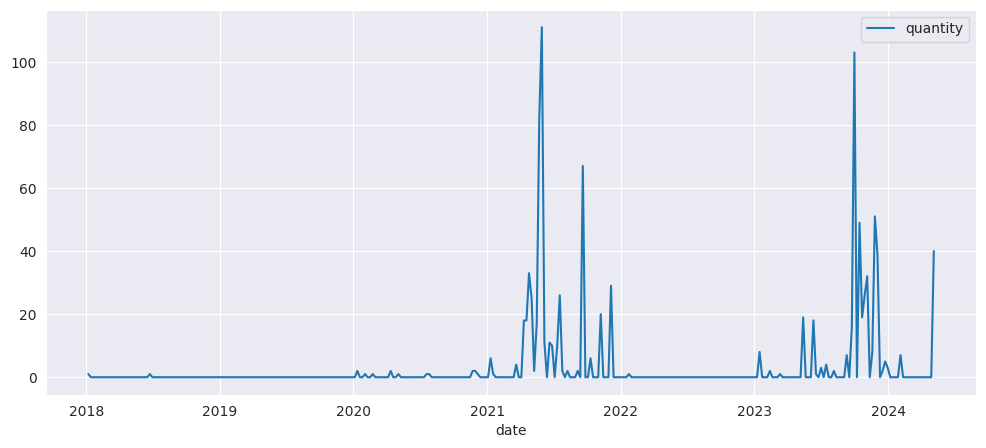

In [11]:
# Построим график
plt.figure(figsize=(12, 5))
sns.set_style("darkgrid")
sns.lineplot(data= analysis_areopag)
plt.show()

In [12]:
# Для анализа и прогноза берем данные с 2021 по 2023 год
df_analysis = analysis_areopag['2021-01-01':'2023-12-31']

In [13]:
# Смотрим количество строк и столбцов
df_analysis.shape

(157, 1)

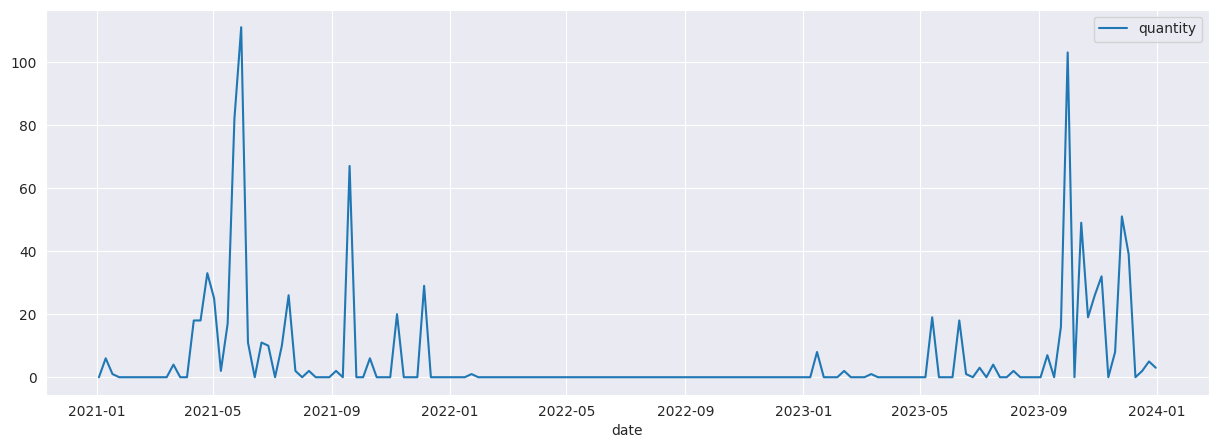

In [14]:
# Построим график по данным отобранным для анализа
plt.figure(figsize=(15, 5))
sns.set_style("darkgrid")
sns.lineplot(data= df_analysis)
plt.show()

- Видим, что практически весь 2022 год в нулях, связано это с нарушением логистики и санкций. Заполним 0 на средние значения, взятое по двум значениям за 2021 и 2023 год, по номеру недели.

In [15]:
# Разобъем данные на отдельные датасеты по годам
df_21 = df_analysis['2021-01-01':'2021-12-31']
df_22 = df_analysis['2022-01-01':'2022-12-31']
df_23 = df_analysis['2023-01-01':'2023-12-31']

In [ ]:
# Проведем замену 0 в 2022 году и 0 в кажом году на среднее значение плавающего ряда. Сохраним все значения в одном датасете.
for i in range(df_21.shape[0]):
  if df_21['quantity'][i] == 0:
    list_ = [x for x in df_21['quantity'][:i]]
    series_ = pd.Series(list_)
    df_21['quantity'][i] = series_.mean()

for i in range(df_23.shape[0]):
  if df_23['quantity'][i] == 0:
    list_ = [x for x in df_23['quantity'][:i]]
    series_ = pd.Series(list_)
    df_23['quantity'][i] = series_.mean()

for i in range(df_22.shape[0]):
  if df_22['quantity'][i] == 0:
    mean_ = (df_21['quantity'][i] + df_23['quantity'][i])/2
    df_22['quantity'][i] = mean_

areopag_analysis = df_21.append(df_22)
areopag_analysis = areopag_analysis.append(df_23)

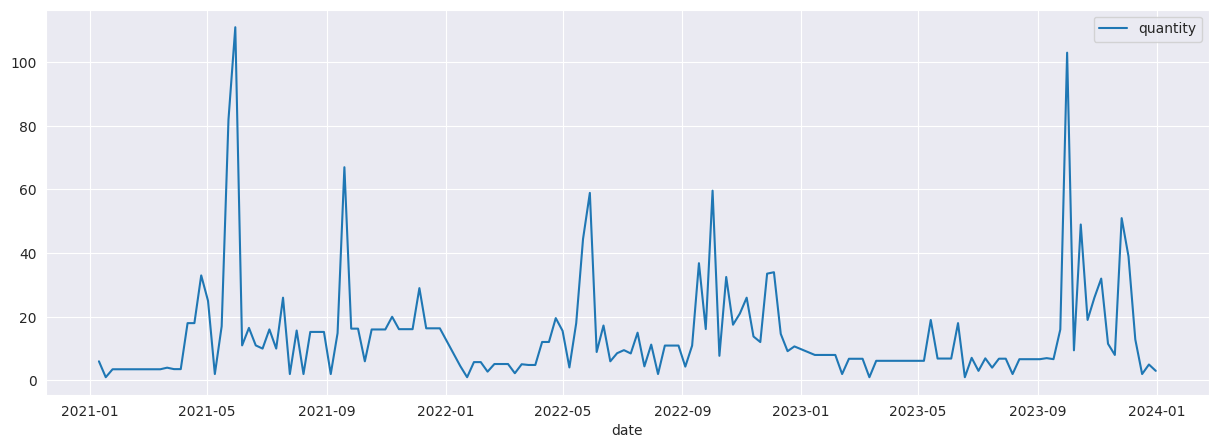

In [17]:
# Построим график полученных данных.
plt.figure(figsize=(15, 5))
sns.set_style("darkgrid")
sns.lineplot(data= areopag_analysis)
plt.show()

In [18]:
# Изменим тип данных и удалим значения Nan
areopag_week = areopag_analysis.dropna().astype('int')

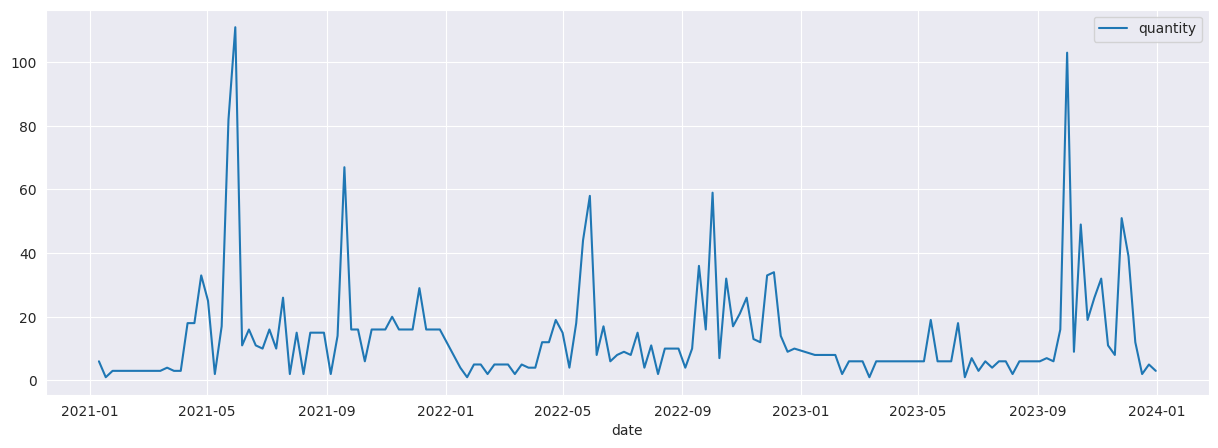

In [19]:
# Построим график
plt.figure(figsize=(15, 5))
sns.set_style("darkgrid")
sns.lineplot(data= areopag_week)
plt.show()

In [20]:
areopag_week

,quantity
date,
2021-01-10,6
2021-01-17,1
2021-01-24,3
2021-01-31,3
2021-02-07,3
...,...
2023-12-03,39
2023-12-10,12
2023-12-17,2


In [21]:
# Разделим датасет понедельно
areopag_week = areopag_week.resample(rule='W').sum()

- Это делаем для того чтобы сохранить понедельную разбивку, которые была потеряна после удаления Nan значений.

2. Анализ подготовленного временного ряда areopag_week

In [24]:
# Импортируем библиотеки для анализа ряда
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

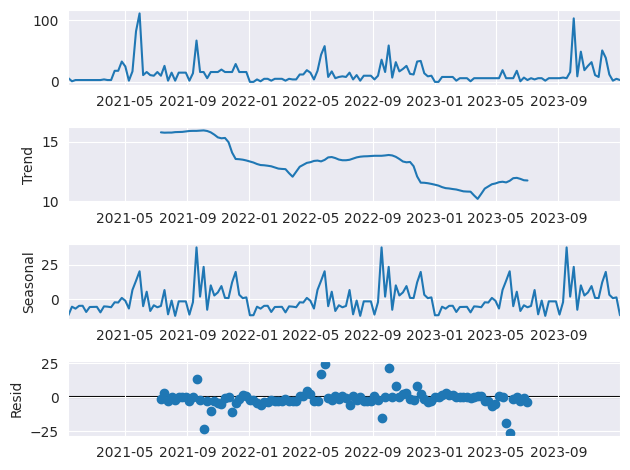

In [25]:
# Разложим временной ряд на компоненты
decompose = seasonal_decompose(areopag_week, model='additive')
decompose.plot()
plt.show()

- Видим по графику что ряд имеет тренд и есть сезонность (в сентябре каждого года)

In [26]:
# Проверим ряд на стационарность с помощью теста Дики-Фуллера. И посмотрим p-value.
test_fuller = adfuller(areopag_week)
print(f'p-value: {test_fuller[1]}')

p-value: 1.3777357805799866e-14


- Тест Дики-Фуллера показывает, что p-value < 0.05, следовательно ряд стационарный.

3. Подбираем модель прогнозирования. Для проверки взята метрика качества MSE

- Устанавливаем библиотеки

In [ ]:
!pip install pmdarima

In [ ]:
!python -m pip install pystan

In [ ]:
!python -m pip install prophet

In [94]:
# импортируем библиотеки
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

In [95]:
# Проведем проверку моделей на обучающих и тестовых данных. Прогноз на 3 месяца, значит горизонт будет равен 12 недель.
horisont = 12
X_train = areopag_week[:len(areopag_week) - horisont]
X_test = areopag_week[len(areopag_week) - horisont:]

In [96]:
# Создаем словарь с моделями прогнозирования
dict_model = {
    'AR': AutoReg,
    'ES': ExponentialSmoothing,
    'ARIMA': ARIMA,
    'Prophet': Prophet,
}

In [ ]:
# Найдем MSE на каждой модели
for name_model in dict_model:
  if name_model == 'AR':
    model = dict_model[name_model](X_train, lags=1)
    fit = model.fit()
    forecast_AR = fit.forecast(len(X_test))
    mse_AR = mean_squared_error(X_test, forecast_AR)

  elif name_model == 'ES':
    model = dict_model[name_model](X_train, initialization_method='estimated', trend='add', seasonal='add')
    fit = model.fit()
    forecast_ES = fit.forecast(len(X_test))
    mse_ES = mean_squared_error(X_test, forecast_ES)

  elif name_model == 'ARIMA':
    auto_ = auto_arima(X_train)
    model = dict_model[name_model](X_train, order=auto_.order)
    fit = model.fit()
    forecast_ARIMA = fit.forecast(len(X_test))
    mse_arima = mean_squared_error(X_test, forecast_ARIMA)

  elif name_model == 'Prophet':
    column_1 = areopag_week.index
    column_2 = areopag_week['quantity'].values
    dict_ = {'ds':column_1, 'y':column_2}
    df_prophet = pd.DataFrame(dict_)
    Xtrain = df_prophet[:len(areopag_week) - horisont]
    Xtest = df_prophet[len(areopag_week) - horisont:]
    model_prophet = dict_model[name_model](interval_width=0.8, seasonality_mode='additive')
    fit_prophet = model_prophet.fit(Xtrain)
    predict_prophet = fit_prophet.make_future_dataframe(periods=len(Xtest), freq='W')
    forecast_prophet = fit_prophet.predict(predict_prophet)
    df_pr = forecast_prophet[['ds', 'yhat']]
    df_pr['date'] = areopag_week.index
    df = df_pr[['date', 'yhat']].set_index('date')[len(areopag_week) - horisont:]
    df_test = Xtest.set_index('ds')
    mse_prophet = mean_squared_error(df_test, df)


In [99]:
# Выведем результат ошибки MSE
print(f"Модель AR - mse = {mse_AR}")
print(f"Модель ES - mse = {mse_ES}")
print(f"Модель ARIMA - mse = {mse_arima}")
print(f"Модель Prophet - mse = {mse_prophet}")

Модель AR - mse = 365.00317771890565
Модель ES - mse = 90.93677385224267
Модель ARIMA - mse = 366.00428814759863
Модель Prophet - mse = 285.6315159195878


- Как мы видим лучший результат показала модель экспоненциального сглаживания (ExponentialSmoothing). Посмотрим по графику полученный результат.

In [100]:
# Создадим датасет, в который занесем полученные результаты по всем моделям
analys_forecast = pd.DataFrame(columns=['date'])

In [101]:
analys_forecast['date'] = X_test.index
analys_forecast['test'] = X_test.values
analys_forecast['AR'] = forecast_AR.values
analys_forecast['ES'] = forecast_ES.values
analys_forecast['ARIMA'] = forecast_ARIMA.values
analys_forecast['PROPHET'] = df['yhat'].values

In [102]:
# Выведем данные
analys_forecast

,date,test,AR,ES,ARIMA,PROPHET
0,2023-10-15,49,11.794594,29.304671,11.753074,14.667214
1,2023-10-22,19,12.694468,14.304671,12.634811,12.118014
2,2023-10-29,26,12.984232,18.304671,12.917209,13.612726
3,2023-11-05,32,13.077537,23.304671,13.007653,14.782296
4,2023-11-12,11,13.107582,10.304671,13.036620,14.382994
5,2023-11-19,8,13.117257,9.304671,13.045898,14.676059
6,2023-11-26,51,13.120372,30.304671,13.048869,17.172041
7,2023-12-03,39,13.121375,31.304670,13.049821,19.770471
8,2023-12-10,12,13.121698,11.304670,13.050125,18.792654
9,2023-12-17,2,13.121802,6.304671,13.050223,13.107975


In [103]:
# Подготовим данные для построения графика
df_AR = analys_forecast[['date','AR']].set_index('date')
df_ES = analys_forecast[['date','ES']].set_index('date')
df_ARIMA = analys_forecast[['date','ARIMA']].set_index('date')
df_PROPHET = analys_forecast[['date','PROPHET']].set_index('date')
df_test = analys_forecast[['date','test']].set_index('date')

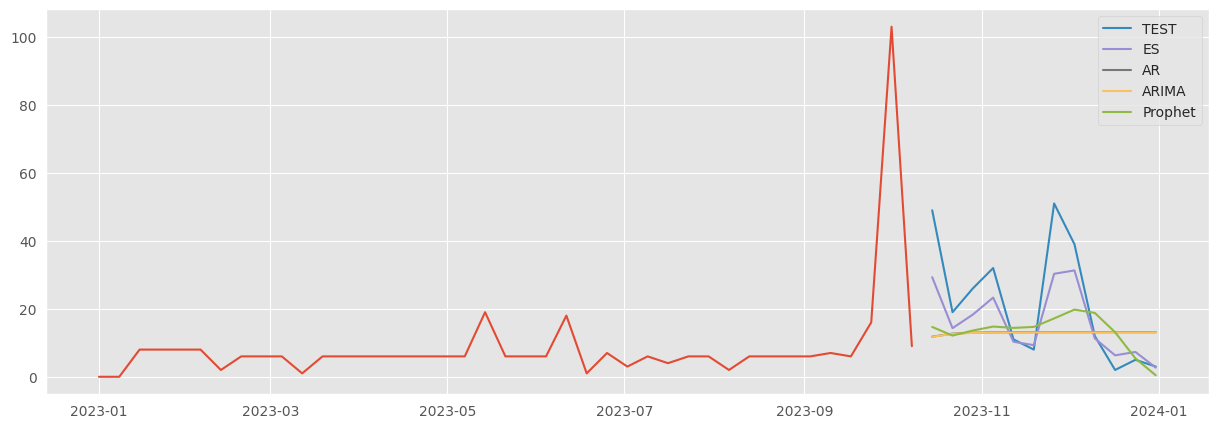

In [104]:
# Построим график полученных результатов и сравним с тестовой выборкой
plt.figure(figsize=(15,5))
plt.plot(X_train['2023-01-01':])
plt.plot(df_test, label='TEST')
plt.plot(abs(df_ES), label='ES')
plt.plot(df_AR, label='AR')
plt.plot(df_ARIMA, label='ARIMA')
plt.plot(abs(df_PROPHET), label='Prophet')
plt.legend()
plt.grid(True)
plt.show()

- График подтверждает, что лучший прогноз получается при использовании модели ExponentialSmoothing. Прогноз будем строить по этой модели.

4. Строим прогноз на 3 месяца.

In [130]:
# Обучение модели и прогноз

train = areopag_week
model = ExponentialSmoothing(train, seasonal='add', trend='add')
fit_model = model.fit()
predict_model = fit_model.predict(start='2024-01-01', end='2024-03-30')

In [131]:
predict_areopag = pd.DataFrame()
predict_areopag['date'] = predict_model.index
predict_areopag['quantity'] = predict_model.values.astype(int)
predict_areopag = predict_areopag.set_index('date')
predict_areopag = predict_areopag.resample(rule='M').sum()

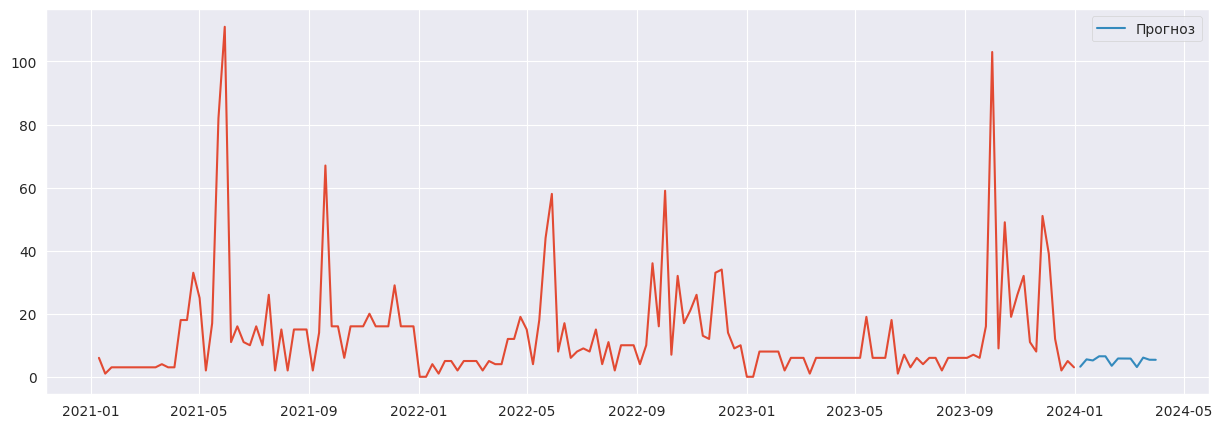

In [132]:
# Построим график
plt.figure(figsize=(15, 5))
sns.set_style("darkgrid")
plt.plot(areopag_week)
plt.plot(predict_model, label='Прогноз')
plt.grid(True)
plt.legend()
plt.show()

In [133]:
predict_areopag

,quantity
date,
2024-01-31,19
2024-02-29,19
2024-03-31,24
